In this notebook I want to present how to implement Linear Regression with Tensorflow.

In [1]:
from sklearn.datasets import make_regression
import tensorflow as tf

%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import numpy as np 

In [2]:
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.2.1


### Constants

In [3]:
# Data parameters
DATA_NUM = 1000
DATA_FEATURES = 1
DATA_LABELS = 1

# Directory to/from which tf.train.Saver will save/load Tensorflow graph
MODEL_SAVE_DIR = "./cpkt_data/"
MODEL_SAVE_FILE_NAME = "tf_linear_regression.cpkt"

# Directory to which tf.summary.FileWriter will save logs
TENSORBOARD_FILES_DIR = "./tensorboard_data/" 

### Generate problem

In [4]:
def generate_linear_regression_problem(samples_num):
    """Function that uses 'make_regression' of sklearn as a core. It's purpose it to 
    generate point that can be aproximated by linear function. Returns tuple of data 
    and it's labels.
    
    Arguments:
    ---------
    samples_num:
        Numer of points that should be generated.
    """
    bias = np.random.uniform(-5, 5)
    data_noise = np.random.uniform(4, 8)
    x_values, y_values = make_regression(n_samples=samples_num, n_features=1, noise=data_noise, 
                                         bias=bias)
    
    return x_values, y_values.reshape(-1, 1)

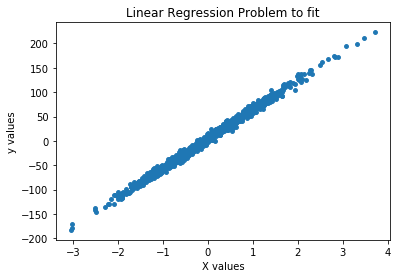

In [5]:
# Generating values 'X' and labels 'y'
X, y = generate_linear_regression_problem(DATA_NUM)

# Presenting generated data
plt.scatter(X, y, s=15)
plt.title("Linear Regression Problem to fit")
plt.xlabel("X values")
plt.ylabel("y values")
plt.show()

### Linear Regression - in Tensorflow

Model implementation

In [6]:
# Resetting Tensorflow graph
tf.reset_default_graph()

with tf.name_scope("io-scope"):
    # Placeholder to which data will be fed to model during training/predicting
    inputs_ = tf.placeholder(tf.float32, [None, DATA_FEATURES], name="inputs")
    
    # Placeholder to which expected values (labels) will be fed to model during training
    targets_ = tf.placeholder(tf.float32, [None, DATA_LABELS], name="targets")

with tf.name_scope("lr-scope"):
    # Placeholder to which learning rate for optimizer will be fed during training
    learning_rate_ = tf.placeholder(tf.float32, None, name="learning_rate")

with tf.name_scope("weights-scope"):
    # Variable - trained part 'weights' of linear function 'weights * inputs_ + bias'
    weights = tf.Variable(tf.random_normal([DATA_FEATURES, 1]), name="weights")

with tf.name_scope("bias-scope"):
    # Variable - trained part 'bias' of linear function 'weights * inputs_ + bias'
    bias = tf.Variable(tf.random_normal([DATA_LABELS]), name="bias")

Model interactions

In [7]:
# Op for making predictions with current 'weights' and 'bias' of model stored in 
# Tensorflow graph
prediction = tf.add(tf.matmul(inputs_, weights), bias)

with tf.name_scope("MSE-scope"):
    # Op for calculating Squared Error cost function for tracking model performance
    mse = tf.reduce_sum(tf.pow(prediction - targets_, 2))/(2*DATA_NUM)
    
    # Tensorboard tracking for Mean Squared Error
    tf.summary.scalar("cost", mse)
    
# Op for optimizing model variables by minimizing Mean Squared Error cost function 
# with usage of Gradient Descent method
optimizer = tf.train.GradientDescentOptimizer(learning_rate_).minimize(mse)

Tensorflow utils for model saving

In [8]:
# Creating tf.train.Saver for storing trained model. Only 'weights' and 'bias' variables
# will be saved
saver = tf.train.Saver([weights, bias])

Tensorflow utils for logging

In [9]:
# Function for providing Tensorboard tf.summary.FileWritter, it needs to have reference to graph
def create_tensorboard_file_writer(session):
    return tf.summary.FileWriter(TENSORBOARD_FILES_DIR, session.graph)

# Op that will merge all tf.summary related logging statements into single object that can be saved
# by FileWriter
gather_graph_data = tf.summary.merge_all()

### Hyperparameters

In [10]:
epochs = 1500
learning_rate = 0.005

### Training cycle

In [11]:
# Container for model preformance tracking - as an alternative to Tensorboard
train = {"cost": list()}

with tf.Session() as sess:
    # Connecting tf.summary.FileWritter to current context session
    file_writer = create_tensorboard_file_writer(sess)
    
    # Adding values to tf.Variables
    sess.run(tf.global_variables_initializer())

    # Training
    for epoch in range(epochs):
        
        # Performing Gradient Descent Step, gathering model data, calculating error
        _, summary, cost = sess.run([optimizer, gather_graph_data, mse], 
                                    feed_dict={inputs_: X, targets_: y, 
                                               learning_rate_: learning_rate})
        
        # Saving calculated error - as an alternative to Tensorboard
        train["cost"].append(cost)
        
        # Saving Tensorboard data
        file_writer.add_summary(summary, epoch)
        
        # Printing model stats every 50 epochs
        if (epoch + 1) % 50 == 0:
            print("Epoch:", "%03d" % (epoch + 1), "cost=", "{:.5f}".format(cost), 
                "weights=", sess.run(weights), "bias=", sess.run(bias))

    # Saving model to .cpkt file
    saver.save(sess, MODEL_SAVE_DIR + MODEL_SAVE_FILE_NAME)

Epoch: 050 cost= 1133.60999 weights= [[ 12.86243248]] bias= [ 2.51129794]
Epoch: 100 cost= 694.24298 weights= [[ 23.25608635]] bias= [ 3.17179561]
Epoch: 150 cost= 427.19440 weights= [[ 31.36148643]] bias= [ 3.64894891]
Epoch: 200 cost= 264.86719 weights= [[ 37.68254471]] bias= [ 3.99153185]
Epoch: 250 cost= 166.18678 weights= [[ 42.61218643]] bias= [ 4.23571634]
Epoch: 300 cost= 106.19300 weights= [[ 46.45676804]] bias= [ 4.40825701]
Epoch: 350 cost= 69.71613 weights= [[ 49.45516968]] bias= [ 4.52888918]
Epoch: 400 cost= 47.53560 weights= [[ 51.7937088]] bias= [ 4.61212826]
Epoch: 450 cost= 34.04727 weights= [[ 53.61761856]] bias= [ 4.66860771]
Epoch: 500 cost= 25.84397 weights= [[ 55.04021072]] bias= [ 4.70608711]
Epoch: 550 cost= 20.85460 weights= [[ 56.14978409]] bias= [ 4.73020411]
Epoch: 600 cost= 17.81970 weights= [[ 57.0152359]] bias= [ 4.74503374]
Epoch: 650 cost= 15.97350 weights= [[ 57.69029236]] bias= [ 4.75350046]
Epoch: 700 cost= 14.85028 weights= [[ 58.21686172]] bias= [

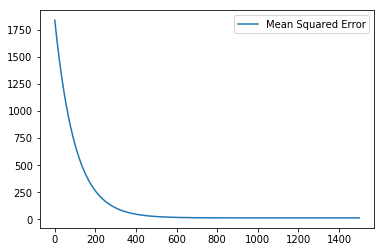

In [12]:
# Model learning history
plt.plot(range(epochs), train["cost"], label="Mean Squared Error")
plt.legend()
plt.show()

### Tensorboard
- Full Tensorboard launch command: 

      tensorboard --logdir=<tensorboard_file_dir>

### Reuse trained model

INFO:tensorflow:Restoring parameters from ./cpkt_data/tf_linear_regression.cpkt


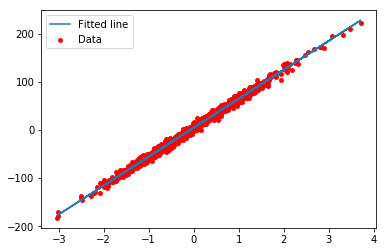

In [13]:
with tf.Session() as sess:
    # Restroing values stored in model .cpkt to current session
    saver.restore(sess, MODEL_SAVE_DIR + MODEL_SAVE_FILE_NAME)
    
    # Using trained model for prediction
    predictions = sess.run([prediction], feed_dict={inputs_: X})
    
    # Displaying predictions on plot
    plt.scatter(X, y, c="r", s=15, label="Data")
    plt.plot(X, predictions[0], label="Fitted line")
    plt.legend()
    plt.show()